In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
import  os
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from utils import Optuna_for_LGB
from preprocess import convert_notation, region_encoding, region_fix
PATH = '../data/'
TRAIN = False

In [2]:
train_df = pd.read_csv(PATH + 'train.csv')
test_df = pd.read_csv(PATH + 'test.csv')
train_df = convert_notation(train_df)
test_df = convert_notation(test_df)
train_df, test_df, le = region_encoding(train_df, test_df)
print(train_df.shape, test_df.shape)
train_df.head()

(4043, 16) (4046, 15)


,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region,tempo_min,tempo_max
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,31,7,121,152
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,23,8,153,176
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,12,4,64,76
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,15,2,177,192
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,23,19,97,120


In [3]:
objective_args = {
    'num_leaves': {
        'type': 'int',
        'suggest_args': {
            'name': 'num_leaves',
            'low': 2,
            'high': 128,
        }
    },
    'max_depth': {
        'type': 'int',
        'suggest_args': {
            'name': 'max_depth',
            'low': 3,
            'high': 8,
        }
    },
    'min_data_in_leaf': {
        'type': 'int',
        'suggest_args': {
            'name': 'min_data_in_leaf',
            'low': 5,
            'high': 90,
        }
    },
    'n_estimators': {
        'type': 'int',
        'suggest_args': {
            'name': 'n_estimators',
            'low': 100,
            'high': 1000,
        }
    },
    'learning_rate': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'learning_rate',
            'low': 0.0001,
            'high': 0.1
        }
    },
    'bagging_fraction': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'bagging_fraction',
            'low': 0.0001,
            'high': 1.0,
        }
    },
    'feature_fraction': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'feature_fraction',
            'low': 0.0001,
            'high': 1.0,
        }
    },
    'random_state': {
        'type': 'default',
        'value': 0
    },
    'objective': {
        'type': 'default',
        'value': 'cross_entropy'
    },
    'num_class': {
        'type': 'default',
        'value': 11
    },
    # 'class_weight': {
    #     'type': 'default',
    #     'value': class_weight
    # }
    
}
def evaluate_macroF1_lgb(true, pred):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred = pred.reshape(len(np.unique(true)), -1).argmax(axis=0)
    f1 = f1_score(true, pred, average='macro')
    return ('macroF1', f1, True) 

pipeline_args = {
    'fit_attr': 'fit',
    'pred_attr': 'predict',
    'fit_args': {
        # 'X': x_train,
        # 'y': y_train,
        # 'eval_set': (x_test, y_test),
        'eval_metric': evaluate_macroF1_lgb,
        'eval_names': ['validation'],
        'early_stopping_rounds': 50,
        'verbose': -1,
        # 'feature_name': columns
        'categorical_feature': ['region']
    },
    # 'pred_args': {'X': x_test},
    'metric': lambda true, pred: f1_score(true, pred, average='macro'),
    # 'metric_args': {'true': y_test},
    'model': lgb.LGBMClassifier,
}

In [4]:
columns = list(test_df.columns)
columns.remove('index')
cv_num = 10
kf = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=0)
thre_count = 1
name = 'lgb_region_fixed_thre_{0}'.format(thre_count)
x, y = train_df[columns], train_df.genre
ofl = Optuna_for_LGB()
optuna.logging.disable_default_handler()
score = list()
for cv, (train_valid_idx, test_idx) in enumerate(kf.split(np.zeros(train_df.shape[0]), y)):
    x_tv, x_test = x.iloc[train_valid_idx], x.iloc[test_idx]
    y_tv, y_test = y.iloc[train_valid_idx], y.iloc[test_idx]
    cv_score = list()
    for valid_cv, (train_idx, valid_idx) in enumerate(kf.split(np.zeros(x_tv.shape[0]), y_tv)):
        x_train, x_valid = x_tv.iloc[train_idx], x_tv.iloc[valid_idx]
        y_train, y_valid = y_tv.iloc[train_idx], y_tv.iloc[valid_idx]
        x_train = x_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        x_train = region_fix(x_train, y_train, thre_count, le.transform(['unknown'])[0])
        pipeline_args['fit_args']['X'] = x_train
        pipeline_args['fit_args']['y'] = y_train
        pipeline_args['fit_args']['eval_set'] = (x_valid, y_valid)
        pipeline_args['fit_args']['feature_name'] = columns
        pipeline_args['pred_args'] = {'X': x_valid}
        pipeline_args['metric_args'] = {'true': y_valid}
        if TRAIN:
            params = ofl.parameter_tuning(pipeline_args, objective_args, 1000, -1, 0)

            best_iteration = params.pop('best_iteration_')
            model = lgb.LGBMClassifier(**params)
            model.fit(**pipeline_args['fit_args'])
            y_pred = model.predict_proba(x_test, model.best_iteration_)
            model.booster_.save_model('../model/{0}_{1}_{2}.txt'.format(name, cv, valid_cv))
        else:
            model = lgb.Booster(model_file='../model/{0}_{1}_{2}.txt'.format(name, cv, valid_cv))
            y_pred = model.predict(x_test).astype(np.float64)

        cv_score.append(f1_score(y_test, np.argmax(y_pred, axis=1), average='macro'))
    score.append(cv_score)

= value
C:\Users\chiru\anaconda3\envs\compe\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\chiru\anaconda3\envs\compe\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\chiru\anaconda3\envs\compe\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [5]:
score, np.mean(score, axis=1), np.mean(score)

([[0.5100962580434721,
   0.5459438622151708,
   0.5162225208139435,
   0.5111670260873502,
   0.5524042725638686,
   0.5243992418371264,
   0.44113648942086103,
   0.4927957857819905,
   0.5328678743779058,
   0.4878140793553216],
  [0.5188286438847067,
   0.5319031421680347,
   0.5113767537786907,
   0.5797255992360648,
   0.5569233903035505,
   0.567627721825414,
   0.4651113636079009,
   0.5262210523299677,
   0.579769020678925,
   0.5530151288875449],
  [0.5323489216932643,
   0.4833484319284597,
   0.5061304080952175,
   0.5361143315693634,
   0.5177818412739903,
   0.5171204631520792,
   0.5183121545359414,
   0.5189291984405858,
   0.5069482896847507,
   0.4850539219486309],
  [0.5720151786497014,
   0.4755784507608489,
   0.5277554964094585,
   0.5324868691926422,
   0.5186265635379645,
   0.4980897677950446,
   0.5117253976820082,
   0.5283586960415699,
   0.5339330164468353,
   0.53866428121374],
  [0.5596962658978664,
   0.5593262493164031,
   0.5077806654012711,
   0.52059

In [6]:
sub_df = pd.read_csv(PATH + 'sample_submit.csv', header=None, names=['ID', 'Pred'])
prediction = np.zeros((test_df.shape[0], 11), dtype=np.float64)
x = test_df[columns]
for i in range(cv_num):
    for j in range(cv_num):
        model = lgb.Booster(model_file='../model/{0}_{1}_{2}.txt'.format(name, i, j))
        pred = model.predict(x).astype(np.float64)
        prediction += pred
prediction /= 100.0
sub_df.Pred = np.argmax(prediction, axis=1)
sub_df.head()

,ID,Pred
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8


<AxesSubplot:>

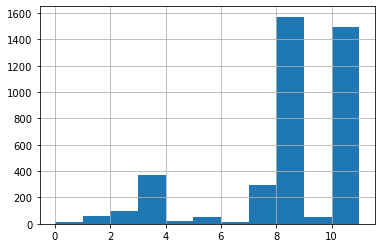

In [7]:
sub_df.Pred.hist(range=(0,11), bins=11)

In [8]:
sub_df.to_csv('../pred/{0}.csv'.format(name), index=None, header=None)